In [1]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

/opt/anaconda3/lib/python3.8/site-packages/shioaji/__init__.py:20: Warning: Mac OS currently don't provide ca module all function about placing order is not working.
  warnings.warn("Mac OS currently don't provide ca module all function about placing order is not working.", Warning)


In [2]:
import talib

def get_technical_indicator(kbars):
    
#     kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
#     macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
#     kbars['macd'] = macd
#     kbars['macdsignal'] = macdsignal
#     kbars['macdhist'] = macdhist
    
        
#     kbars['slowk'], kbars['slowd'] = talib.STOCH(kbars.high,
#                         kbars.low,
#                         kbars.close,
#                         fastk_period=9,
#                         slowk_period=3,
#                         slowk_matype=0,
#                         slowd_period=3,
#                         slowd_matype=0)

    upper, middle, lower = talib.BBANDS(kbars.close, 
                                        timeperiod=20, 
                                        nbdevup=2.1, 
                                        nbdevdn=2.1, 
                                        # Moving average type: simple moving average here
                                        matype=0)
    kbars['upper'] = upper
    kbars['middle'] = middle
    kbars['lower'] = lower
    
    return kbars

In [3]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    
    ticks = get_ticks(code, prev_trading_date, connection, api)[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks, '1Min')
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    kbars = kbars[date:]
    
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
    open_price = 0
            
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]
        if ts == 0: 
            open_price = kbars['open'][ts]
            continue
        if ts ==1:
            if(kbars['close'][0] >= open_price * 1.04):
                break
#             continue
        
        if (
            current_time <= date.replace(hour=10, minute=30, second=0) and
            kbars.iloc[ts-1]['cci'] < -350 and
            kbars.iloc[ts-2]['lower'] > current_price and  
            position == 0
        ):
            if current_price < 20:
                position = 20
            else:
                position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        
        elif (
#             (current_price > open_price * 1.095 and position != 0) or
            (current_price >= entry_price * 1.03 and position != 0) or
            (current_price <= entry_price * 0.975 and position != 0) or
            (
            entry_price < current_price and
            kbars.iloc[ts-1]['upper'] < current_price and 
            position != 0)
        ):
            exit_price = current_price
            exit_time = current_time.time()
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
        elif (
            current_time >= date.replace(hour=13, minute=24, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

In [4]:
import json

with open('config.json') as f:
  config = json.load(f)

api = sj.Shioaji()
api.login(
    person_id = config['account'],
    passwd= config['password'],
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
<SecurityType.Index: 'IND'> fetch done.


In [5]:
def get_trading_codes(codes, connection, api):
    trading_codes = []
    for code in codes:
        stock = get_stock(code, connection, api)
        if not stock[0].empty and stock[0].iloc[0]['day_trade'] == 'Yes':
            trading_codes.append(code)
    return trading_codes

In [6]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)

#         day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        day_trading_codes = get_trading_codes(codes, connection, api)
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [7]:
transactions = backtest('2020/1/1', '2020/12/31', connection, api)
transactions 

<SecurityType.Future: 'FUT'> fetch done.
<SecurityType.Stock: 'STK'> fetch done.
<SecurityType.Option: 'OPT'> fetch done.
[2020-01-06 09:37:00] buy 2614 at 10.75
[2020-01-06 13:24:00] sell 2614 at 10.9
[2020-01-06 09:01:00] buy 3530 at 108.0
[2020-01-06 10:08:00] sell 3530 at 109.0
[2020-01-08 09:01:00] buy 2455 at 108.0
[2020-01-08 10:05:00] sell 2455 at 109.5
[2020-01-20 10:30:00] buy 2369 at 11.5
[2020-01-20 13:24:00] sell 2369 at 11.5
[2020-01-31 09:01:00] buy 6176 at 103.5
[2020-01-31 09:02:00] sell 6176 at 104.0
[2020-02-03 09:01:00] buy 2537 at 10.1
[2020-02-03 09:38:00] sell 2537 at 10.15
[2020-02-03 09:01:00] buy 3044 at 106.0
[2020-02-03 09:07:00] sell 3044 at 102.5
[2020-02-03 09:01:00] buy 6416 at 108.0
[2020-02-03 09:35:00] sell 6416 at 108.5
[2020-02-03 09:01:00] buy 2455 at 96.5
[2020-02-03 09:05:00] sell 2455 at 93.8
[2020-02-03 09:01:00] buy 6531 at 102.5
[2020-02-03 09:34:00] sell 6531 at 104.0
[2020-02-03 09:01:00] buy 6176 at 101.0
[2020-02-03 09:43:00] sell 6176 at

[2020-06-12 09:01:00] buy 4943 at 109.5
[2020-06-12 09:45:00] sell 4943 at 111.5
[2020-06-12 09:01:00] buy 5215 at 98.8
[2020-06-12 09:52:00] sell 5215 at 100.5
[2020-06-12 09:01:00] buy 9802 at 102.5
[2020-06-12 09:38:00] sell 9802 at 105.5
[2020-06-12 09:01:00] buy 2377 at 99.7
[2020-06-12 09:38:00] sell 2377 at 101.5
[2020-06-12 09:01:00] buy 1802 at 9.46
[2020-06-12 09:13:00] sell 1802 at 9.76
[2020-06-12 09:01:00] buy 1536 at 100.5
[2020-06-12 09:41:00] sell 1536 at 103.5
[2020-06-12 09:01:00] buy 6456 at 109.0
[2020-06-12 09:38:00] sell 6456 at 111.0
[2020-06-12 09:01:00] buy 00712 at 10.38
[2020-06-12 09:55:00] sell 00712 at 10.64
[2020-06-12 09:01:00] buy 2369 at 10.1
[2020-06-12 09:40:00] sell 2369 at 10.35
[2020-06-16 10:30:00] buy 1536 at 107.5
[2020-06-16 13:24:00] sell 1536 at 107.0
[2020-06-30 09:20:00] buy 4133 at 97.0
[2020-06-30 13:30:00] sell 4133 at 96.0
[2020-07-09 09:04:00] buy 5521 at 10.45
[2020-07-09 10:48:00] sell 5521 at 10.15
[2020-07-14 09:03:00] buy 9902 at

,股票代號,買進時間,買進價格,買進股數,買進金額,賣出時間,賣出價格,賣出股數,賣出金額,買進手續費,賣出手續費,交易稅,損益
成交日期,,,,,,,,,,,,,
2020-01-06,2614,09:37:00,10.75,20000,215000.0,13:24:00,10.90,20000,218000.0,116,118,327,2439.0
2020-01-06,3530,09:01:00,108.00,2000,216000.0,10:08:00,109.00,2000,218000.0,116,118,327,1439.0
2020-01-08,2455,09:01:00,108.00,2000,216000.0,10:05:00,109.50,2000,219000.0,116,118,328,2438.0
2020-01-20,2369,10:30:00,11.50,20000,230000.0,13:24:00,11.50,20000,230000.0,124,124,345,-593.0
2020-01-31,6176,09:01:00,103.50,2000,207000.0,09:02:00,104.00,2000,208000.0,112,112,312,464.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,1536,10:24:00,104.00,2000,208000.0,10:40:00,105.00,2000,210000.0,112,113,315,1460.0
2020-12-23,1723,10:26:00,106.00,2000,212000.0,10:49:00,107.00,2000,214000.0,114,115,321,1450.0
2020-12-23,1314,09:52:00,10.30,20000,206000.0,10:10:00,10.45,20000,209000.0,111,113,313,2463.0


In [8]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2020-01-06,431000.0,232,436000.0,236,654,3878.0,2.0
2020-01-08,216000.0,116,219000.0,118,328,2438.0,1.0
2020-01-20,230000.0,124,230000.0,124,345,-593.0,1.0
2020-01-31,207000.0,112,208000.0,112,312,464.0,1.0
2020-02-03,1429200.0,770,1426600.0,769,2137,-6276.0,7.0
...,...,...,...,...,...,...,...
2020-12-15,435200.0,235,424000.0,229,635,-12299.0,2.0
2020-12-22,420000.0,226,424000.0,228,636,2910.0,2.0
2020-12-23,418000.0,225,423000.0,228,634,3913.0,2.0


In [9]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2020-01-31,1084000.0,584,1093000.0,590,1639,6187.0,5.0
2020-02-29,3120200.0,1683,3135600.0,1692,4698,7327.0,15.0
2020-03-31,12561600.0,6771,12743000.0,6871,19099,148659.0,61.0
2020-04-30,1642000.0,885,1649600.0,889,2472,3354.0,8.0
2020-05-31,1469000.0,793,1493000.0,805,2237,20165.0,7.0
2020-06-30,3278000.0,1769,3324800.0,1792,4982,38257.0,16.0
2020-07-31,1660800.0,895,1667600.0,899,2498,2508.0,8.0
2020-08-31,2116000.0,1141,2150000.0,1160,3223,28476.0,10.0
2020-09-30,6161400.0,3321,6239000.0,3365,9352,61562.0,29.0


In [10]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

306014.9999999999

In [11]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

0.821

In [12]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 -24515.0


[Text(0.5, 0, 'profit loss')]

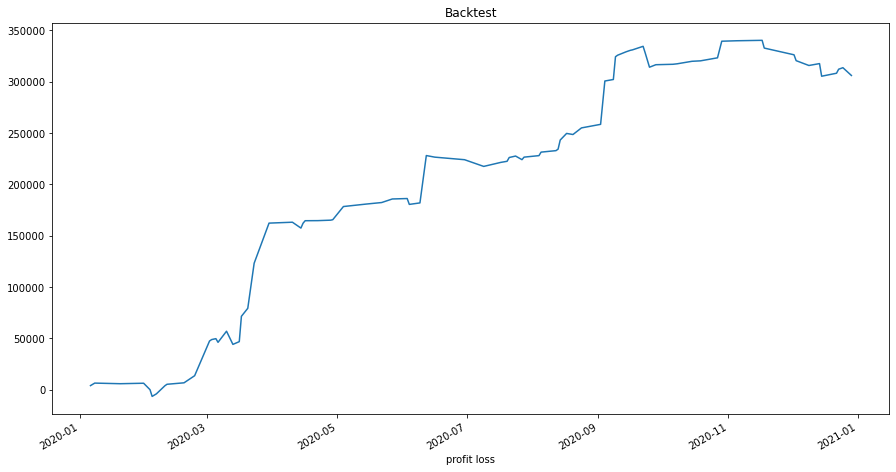

In [13]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')